# Step 1: Instruction Fine-Tuning GPT-2

In [ ]:
!pip install datasets #허깅페이스
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, pipeline, \
                         AutoTokenizer, AutoModelForCausalLM
import pandas as pd
from datasets import Dataset, load_dataset
import torch
import json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
seed=42

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda")

device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
data_path = '/content/drive/MyDrive/fine tuning/chip2.csv'
training_df = pd.read_csv(data_path)                #####csv를 데이터프레임으로 변환


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


![Screenshot%202023-08-02%20at%206.48.20%20AM.png](attachment:Screenshot%202023-08-02%20at%206.48.20%20AM.png)

Find it [here](https://laion.ai/blog/oig-dataset/)

In [ ]:
training_df.head()

,prompt,response,source
0,What is the name of the architect of the DeGol...,The architect of the DeGolyer House is Richard...,unified_chip2
1,Why did the US invade Iraq?,The US invaded Iraq in 2003 based on the belie...,unified_chip2
2,Can I make a typhoid vaccine?,"Yes, typhoid vaccines are available and can be...",unified_chip2
3,What's the best way to deal with an annoying c...,It's always best to approach the situation cal...,unified_chip2
4,Is it safe to drink alcohol if I have a histor...,"No, it is not safe to drink alcohol if you hav...",unified_chip2


In [ ]:
print(training_df.iloc[798]['prompt'])            ##### iloc는 798은 데이터프레임의 799번째 행
print("========")
print(training_df.iloc[798]['response'])
print("========")


Is there a list of all the U.S. presidents and when they served?
Yes, here is a list of all the U.S. presidents in chronological order and the dates they served:

George Washington (1789-1797)
John Adams (1797-1801)
Thomas Jefferson (1801-1809)
James Madison (1809-1817)
James Monroe (1817-1825)
John Quincy Adams (1825-1829)
Andrew Jackson (1829-1837)
Martin Van Buren (1837-1841)
William Henry Harrison (1841)
John Tyler (1841-1845)
James K. Polk (1845-1849)
Zachary Taylor (1849-1850)
Millard Fillmore (1850-1853)
Franklin Pierce (1853-1857)
James Buchanan (1857-1861)
Abraham Lincoln (1861-1865)
Andrew Johnson (1865-1869)
Ulysses S. Grant (1869-1877)
Rutherford B. Hayes (1877-1881)
James A. Garfield (1881)
Chester A. Arthur (1881-1885)
Grover Cleveland (1885-1889)
Benjamin Harrison (1889-1893)
Grover Cleveland (1893-1897)
William McKinley (1897-1901)
Theodore Roosevelt (1901-1909)
William Howard Taft (1909-1913)
Woodrow Wilson (1913-1921)
Warren G. Harding (1921-1923)
Calvin Coolidge (192

In [ ]:
training_df.head()

,prompt,response,source
0,What is the name of the architect of the DeGol...,The architect of the DeGolyer House is Richard...,unified_chip2
1,Why did the US invade Iraq?,The US invaded Iraq in 2003 based on the belie...,unified_chip2
2,Can I make a typhoid vaccine?,"Yes, typhoid vaccines are available and can be...",unified_chip2
3,What's the best way to deal with an annoying c...,It's always best to approach the situation cal...,unified_chip2
4,Is it safe to drink alcohol if I have a histor...,"No, it is not safe to drink alcohol if you hav...",unified_chip2


In [ ]:
training_df.shape

(173734, 3)

In [ ]:
training_df['response'] = training_df['response'].map(lambda x: x.strip())   ##### map은 각요소에 함수적용 , 익명함수 람다, 각요소x에대해 strip()공백제거
training_df['prompt'] = training_df['prompt'].map(lambda x: x.strip())


In [ ]:
training_df = training_df.drop_duplicates(subset=['prompt'])                 ##### prompt 열을 기준으로 중복을 제거

In [ ]:
training_df.shape

(112097, 3)

In [ ]:
training_df.head(2)

,prompt,response,source
0,What is the name of the architect of the DeGol...,The architect of the DeGolyer House is Richard...,unified_chip2
1,Why did the US invade Iraq?,The US invaded Iraq in 2003 based on the belie...,unified_chip2


<Axes: xlabel='source'>

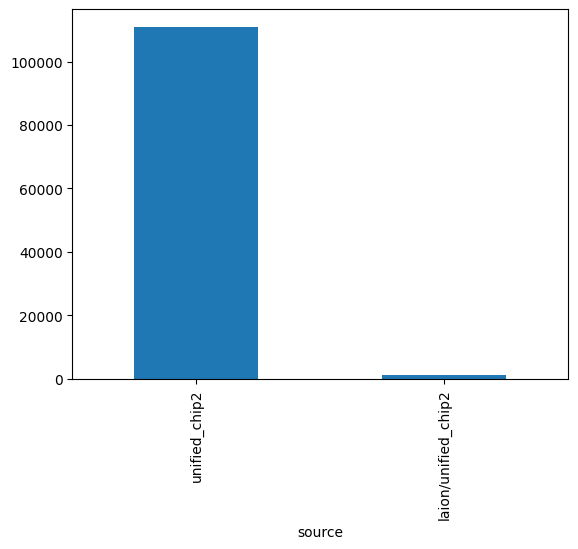

In [ ]:
training_df['source'].value_counts().plot(kind='bar')                      ##### 종류별분류

In [ ]:
training_df.shape

(112097, 3)

<Axes: title={'center': 'Histogram of prompt Length'}, ylabel='Frequency'>

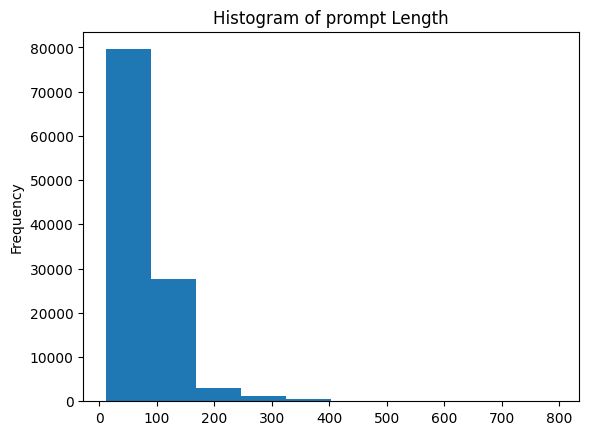

In [ ]:
training_df['prompt'].str.len().plot(kind='hist', title='Histogram of prompt Length')

<Axes: title={'center': 'Histogram of response Length'}, ylabel='Frequency'>

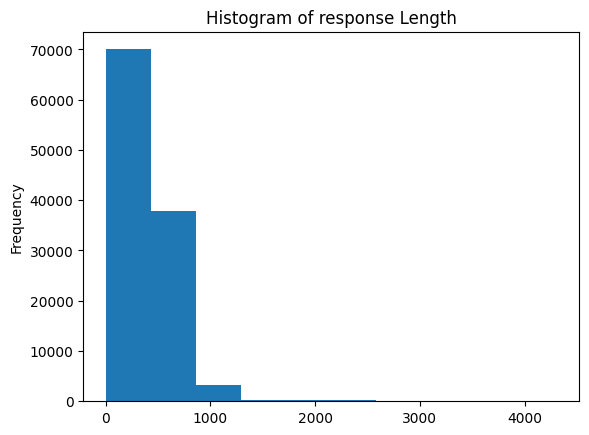

In [ ]:
training_df['response'].str.len().plot(kind='hist', title='Histogram of response Length')


  
# 모델학습 시작


In [ ]:
QUERY_KEY = "Question:"
RESPONSE_KEY = "Response:"
PAD_KEY = "<PAD>"


In [ ]:

MODEL = 'gpt2'

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# 사용자토큰정의
# 일반적인 특수 토큰(e.g., <pad>, <cls>) 외에 추가로 사용자 정의 특수 토큰을 포함
# 질문,답변을 구분 / 예:"What is AI?"를 "<QUERY> What is AI?"로 변환. / 입력 시퀀스의 길이를 맞추기 위해 패딩 토큰을 사용
tokenizer.add_special_tokens({"additional_special_tokens": [QUERY_KEY, RESPONSE_KEY, PAD_KEY]})
tokenizer.pad_token = PAD_KEY


model = AutoModelForCausalLM.from_pretrained(MODEL)
model.config.pad_token = PAD_KEY
model.resize_token_embeddings(len(tokenizer))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(50260, 768)

In [ ]:
chip2_dataset = Dataset.from_pandas(training_df)                ##### 허깅페이스 Dataset라이브러리로 pandas 데이터프레임을 처리

# 사용자토큰 적용함수
def preprocess(example):
    return tokenizer(QUERY_KEY+ ' ' + example['prompt'] + '\n'+RESPONSE_KEY+' '+example['response']+tokenizer.eos_token)

chip2_dataset = chip2_dataset.map(
    preprocess, batched=False, batch_size=1024, remove_columns=chip2_dataset.features.keys()
)

# 길이조정함수
def filter_function(example):
    return len(example['input_ids']) <= 1024

chip2_dataset = chip2_dataset.filter(filter_function)

chip2_dataset = chip2_dataset.train_test_split(test_size=0.2, seed=seed)

Map:   0%|          | 0/112097 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1446 > 1024). Running this sequence through the model will result in indexing errors


Filter:   0%|          | 0/112097 [00:00<?, ? examples/s]

In [ ]:
chip2_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 89676
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 22419
    })
})

In [ ]:
print(tokenizer.decode(chip2_dataset['test']['input_ids'][13]))
print('-----')
print(tokenizer.decode(chip2_dataset['test']['input_ids'][14]))
print('-----')
print(tokenizer.decode(chip2_dataset['test']['input_ids'][63]))

Question: What is the name of the character played by Emily Blunt in the movie ‘The Young Victoria’?
Response: Queen Victoria<|endoftext|>
-----
Question: How is a blockchain ledger used?
Response: A blockchain ledger is primarily used for recording and verifying transactions in a secure and decentralized manner. Every participant in the network has a copy of the ledger, creating transparency and traceability of all transactions. It is commonly used in cryptocurrencies and other financial applications, but can also have uses in supply chain management, voting systems, and more.<|endoftext|>
-----
Question: Can you give me an overview of the elements of the periodic table?
Response: The periodic table is a tabular arrangement of chemical elements based on their atomic number, electron configuration, and chemical properties. It is divided into rows called periods and columns called groups. There are currently 118 known elements, each with its unique set of properties. The elements are or

In [ ]:
len(chip2_dataset['test']['input_ids'][0])

102

In [ ]:
f'{model.num_parameters():,}'

'124,442,112'

In [ ]:
import wandb                  #### 모델학습 추적, 시각화
# Set up Weights and Biases integration
wandb.init(project="FFT") #b93a105e31d833b072c1f15f57a095f50c62e0d3


In [ ]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
print(torch.cuda.get_device_name(0))
if device.type == 'cuda':
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA A100-SXM4-40GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False,
    return_tensors="pt", pad_to_multiple_of=8
)

In [ ]:
from transformers import TrainingArguments, Trainer

##### 실험설정 다르게 2번돌림
training_args = TrainingArguments(
    output_dir="./fineframe_supervised_instruction",  # The output directory
    overwrite_output_dir=True,  # overwrite the content of the output directory
    num_train_epochs=1,  # number of training epochs
    per_device_train_batch_size=2,  # batch size for training
    per_device_eval_batch_size=4,  # batch size for evaluation
    gradient_accumulation_steps=16,  # steps for gradient accumulation
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    report_to="all",
    seed=seed,
    fp16=True,  # enable mixed precision training for my GPU
)

# GPT2모델을 chip2데이터셋으로 훈련시킨다 (fine tuning)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=chip2_dataset['train'],
    eval_dataset=chip2_dataset['test'],
    data_collator=data_collator
)

trainer.evaluate()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


{'eval_loss': 2.9964849948883057,
 'eval_model_preparation_time': 0.0027,
 'eval_runtime': 80.2634,
 'eval_samples_per_second': 279.318,
 'eval_steps_per_second': 69.833}

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./fineframe",  # The output directory
    overwrite_output_dir=True,  # overwrite the content of the output directory
    num_train_epochs=1,  # number of training epochs
    per_device_train_batch_size=2,  # batch size for training
    per_device_eval_batch_size=4,  # batch size for evaluation
    gradient_accumulation_steps=16,  # steps for gradient accumulation
    logging_steps=50,
    learning_rate=2e-5,
    warmup_steps=100,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    report_to="all",
    seed=seed,
    fp16=True,  # enable mixed precision training for GPU
)

##### transformers라이브러리 Trainer에 모델, args, 데이터셋 넣고 train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=chip2_dataset['train'],
    eval_dataset=chip2_dataset['test'],
    data_collator=data_collator
)

trainer.evaluate()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'eval_loss': 2.9964849948883057,
 'eval_model_preparation_time': 0.0026,
 'eval_runtime': 80.6417,
 'eval_samples_per_second': 278.007,
 'eval_steps_per_second': 69.505}

In [ ]:
number_of_examples = len(chip2_dataset['train'])
per_device_train_batch_size = training_args.per_device_train_batch_size
gradient_accumulation_steps = training_args.gradient_accumulation_steps
num_train_epochs = training_args.num_train_epochs

effective_batch_size = per_device_train_batch_size * gradient_accumulation_steps
number_of_training_steps = (number_of_examples / effective_batch_size) * num_train_epochs

number_of_training_steps = int(number_of_training_steps / training_args.n_gpu)

print("Number of training steps:", number_of_training_steps)


Number of training steps: 2802


In [ ]:
training_args.warmup_steps = int(.1 * number_of_training_steps)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Model Preparation Time
0,2.059700,1.940167,0.002600


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=2802, training_loss=2.181821067191974, metrics={'train_runtime': 1717.8187, 'train_samples_per_second': 52.203, 'train_steps_per_second': 1.631, 'total_flos': 6394844860416000.0, 'train_loss': 2.181821067191974, 'epoch': 0.9998661849324234})

In [ ]:
# 모델 저장
model_save_path = "/content/drive/My Drive/fine tuning/trained_model"
tokenizer_save_path = "/content/drive/My Drive/fine tuning/trained_model/tokenizer"

trainer.save_model(model_save_path)

In [ ]:
tokenizer.save_pretrained(tokenizer_save_path)


('/content/drive/My Drive/fine tuning/trained_model/tokenizer/tokenizer_config.json',
 '/content/drive/My Drive/fine tuning/trained_model/tokenizer/special_tokens_map.json',
 '/content/drive/My Drive/fine tuning/trained_model/tokenizer/vocab.json',
 '/content/drive/My Drive/fine tuning/trained_model/tokenizer/merges.txt',
 '/content/drive/My Drive/fine tuning/trained_model/tokenizer/added_tokens.json',
 '/content/drive/My Drive/fine tuning/trained_model/tokenizer/tokenizer.json')

**모델을 구글드라이브에 저장된것을 불러옴**




In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# 저장된 경로
model_load_path = "/content/drive/My Drive/fine tuning/trained_model"
tokenizer_load_path = "/content/drive/My Drive/fine tuning/trained_model/tokenizer"

# 모델 및 토크나이저 로드
model = AutoModelForCausalLM.from_pretrained(model_load_path)    # 처음엔 model = AutoModelForCausalLM.from_pretrained("GPT2")
# 모델사용 목적이다름, CausalLM 모델은 언어 생성에 필요한 자동 회귀 방식으로 학습됩니다.
# Sequence Classification 모델은 분류 작업을 위한 엔드 투 엔드 분류 구조로 학습됩니다. AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(tokenizer_load_path)

### Loss drops dramatically which is expected when we introduce new tokens
